# Visualize a BioBombe Application

## Neutrophil and Monocyte Signatures Derived from GTEx Data with xCell gene sets

**Gregory Way, 2018**

Generating one main and two supplementary figures describing the BioBombe application in GTEx.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(ggpmisc))
suppressPackageStartupMessages(library(svglite))

# Load custom plotting functions
util_file = file.path("..", "6.biobombe-projection", "scripts", "utils.R")
source(util_file)

Warning message:
“As of rlang 0.4.0, dplyr must be at least version 0.8.0.
* dplyr 0.7.6 is too old for rlang 0.4.5.
* Please update dplyr with `install.packages("dplyr")` and restart R.”


In [2]:
set.seed(123)

In [3]:
fig_extensions <- c('.png', '.pdf', '.svg')

## Part 1 - Generate Supplementary Figure 1

In [4]:
# Setup plotting logic
vae_labels <- c("vae_0_two" = "k = 2 (0)",
                "vae_1_two" = "k = 2 (1)",
                "vae_0_three" = "k = 3 (0)",
                "vae_1_three" = "k = 3 (1)",
                "vae_2_three" = "k = 3 (2)")

vae_colors <- c("#c994c7",
                "#dd1c77",
                "#78c679",
                "#31a354",
                "#006837")

### Supplementary Figure 1 Panel A: Visualize the Overrepresentation Results

In [5]:
results_file <- file.path('results', 'gtex_vae_example_overrepresentation.tsv')
overrep_data_df <- (
    readr::read_tsv(results_file,
                    col_types = readr::cols(.default = readr::col_integer(),
                                            variable = readr::col_character(),
                                            full_feature = readr::col_character(),
                                            odds = readr::col_double(),
                                            pval = readr::col_double(),
                                            tailed = readr::col_character()))
    )

overrep_data_df$full_feature <- factor(overrep_data_df$full_feature,
                                       levels = c("vae_0_two",
                                                  "vae_1_two",
                                                  "vae_0_three",
                                                  "vae_1_three",
                                                  "vae_2_three"))

overrep_data_df$neg_log10_p <- -log10(overrep_data_df$pval)
head(overrep_data_df %>% dplyr::arrange(desc(neg_log10_p)))

variable,pval,odds,full_feature,tailed,neg_log10_p
<chr>,<dbl>,<dbl>,<fct>,<chr>,<dbl>
Keratinocytes_FANTOM_3,2.455426e-22,18.49730,vae_1_three,neg,21.60987
Keratinocytes_FANTOM_2,1.569034e-21,18.27418,vae_1_three,neg,20.80437
Keratinocytes_FANTOM_1,1.069778e-19,11.36356,vae_1_three,neg,18.97071
Keratinocytes_HPCA_3,3.081031e-19,22.05901,vae_1_three,neg,18.51130
Skeletal-muscle_FANTOM_2,1.833130e-18,26.29440,vae_0_two,pos,17.73681
Keratinocytes_HPCA_2,1.561197e-17,17.05444,vae_1_three,neg,16.80654


In [6]:
color_logic <- overrep_data_df$neg_log10_p > 10

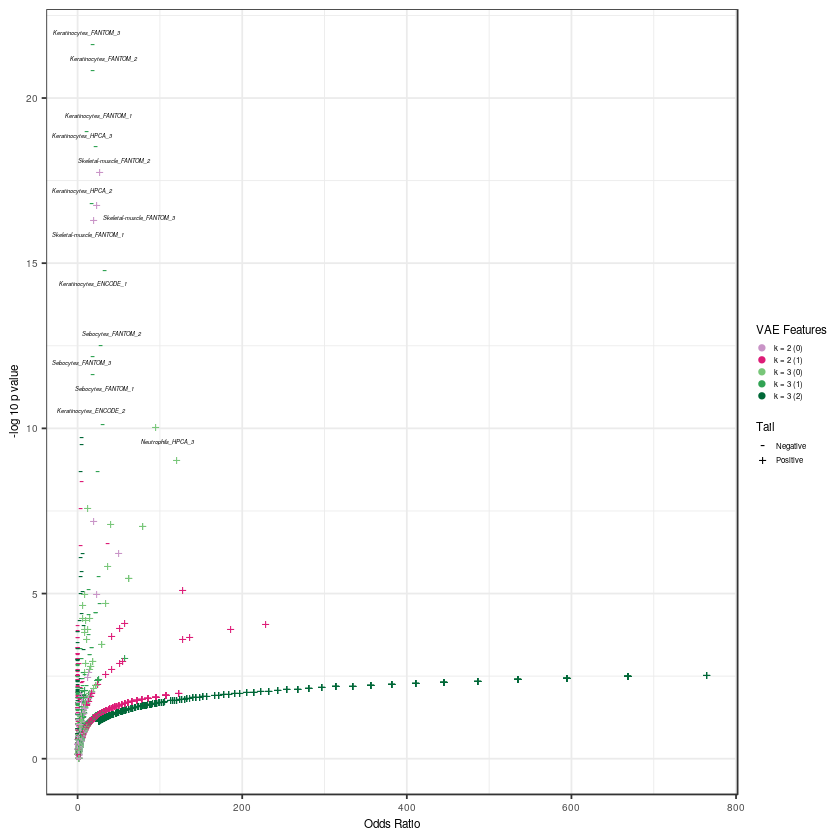

In [7]:
# Create Panel A for a Supplementary Figure
sup_panel_a_gg <- ggplot(overrep_data_df,
                         aes(x = odds,
                             y = neg_log10_p,
                             shape = tailed)) +
    geom_point(aes(color = as.factor(full_feature)),
                   size = 3) +
    scale_color_manual(name = "VAE Features",
                       values = vae_colors,
                       labels =  vae_labels) +
    scale_shape_manual(name = "Tail",
                       values = c("-", "+"),
                       labels = c("pos" = "Positive",
                                  "neg" = "Negative")) +
    geom_text_repel(data = subset(overrep_data_df, color_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    segment.size = 0.3,
                    segment.alpha = 0.6,
                    size = 1.2,
                    fontface = "italic",
                    box.padding = 0.25,
                    point.padding = 0.15,
                    aes(x = odds,
                        y = neg_log10_p,
                        label = variable)) +
    xlab("Odds Ratio") +
    ylab("-log 10 p value") +
    theme_bw() +
    theme(axis.title = element_text(size = 7),
          axis.text.x = element_text(size = 6),
          axis.text.y = element_text(size = 6),
          legend.position = 'right',
          legend.title = element_text(size = 7),
          legend.text = element_text(size = 4.7),
          legend.margin = margin(0, 0, 0, 0),
          legend.box.margin = margin(-8, 0, 0, 0)) +
    guides(color = guide_legend(order = 1,
                                nrow = 5,
                                ncol = 1,
                                byrow = FALSE,
                                keywidth = 0.1,
                                keyheight = 0.1,
                                default.unit = "inch",
                                override.aes = list(size = 1.4,
                                                    alpha = 1)),
           shape = guide_legend(order = 2,
                                nrow = 2,
                                ncol = 1,
                                byrow = FALSE,
                                keywidth = 0.1,
                                keyheight = 0.1,
                                default.unit = "inch"))

sup_panel_a_gg

### Supplementary Figure 2 Panel B: Compare BioBombe Network Projection Approach with Overrepresentation

#### Combine Results and Plot in Single Figure

In [8]:
results_file <- file.path('results', 'gtex_vae_example_interpret_compression.tsv')
interpret_data_df <- (
    readr::read_tsv(results_file,
                    col_types = readr::cols(.default = readr::col_character(),
                                            raw_score = readr::col_double(),
                                            z_score = readr::col_double()))
    )

interpret_data_df$full_feature <- factor(interpret_data_df$full_feature,
                                  levels = c("vae_0_two", "vae_1_two", "vae_0_three",
                                             "vae_1_three", "vae_2_three"))

head(interpret_data_df)

model_type,full_feature,variable,raw_score,z_score
<chr>,<fct>,<chr>,<dbl>,<dbl>
real,vae_2_three,Keratinocytes_HPCA_3,-10.901510,-33.32254
real,vae_1_two,Keratinocytes_HPCA_3,-10.564337,-30.32630
real,vae_1_three,Sebocytes_FANTOM_3,-9.071379,-25.20342
real,vae_2_three,Keratinocytes_ENCODE_1,-6.572572,-23.50536
real,vae_1_three,Sebocytes_FANTOM_1,-8.317615,-21.20593
real,vae_2_three,Sebocytes_FANTOM_1,-6.761970,-19.13752


In [9]:
combined_results_df <- overrep_data_df %>%
    dplyr::full_join(interpret_data_df,
                     by = c('variable', 'full_feature'))

head(combined_results_df)

Warning message:
“`chr_along()` is deprecated as of rlang 0.2.0.
This warning is displayed once per session.”


variable,pval,odds,full_feature,tailed,neg_log10_p,model_type,raw_score,z_score
<chr>,<dbl>,<dbl>,<fct>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
Keratinocytes_FANTOM_3,2.455426e-22,18.49730,vae_1_three,neg,21.60987,real,-17.642717,-14.96365
Keratinocytes_FANTOM_2,1.569034e-21,18.27418,vae_1_three,neg,20.80437,real,-17.210515,-14.71681
Keratinocytes_FANTOM_1,1.069778e-19,11.36356,vae_1_three,neg,18.97071,real,-20.945504,-11.81928
Keratinocytes_HPCA_3,3.081031e-19,22.05901,vae_1_three,neg,18.51130,real,-11.919360,-19.00494
Skeletal-muscle_FANTOM_2,1.833130e-18,26.29440,vae_0_two,pos,17.73681,real,7.981099,18.05253
Keratinocytes_HPCA_2,1.561197e-17,17.05444,vae_1_three,neg,16.80654,real,-12.166610,-14.14869


In [10]:
color_logic <- (combined_results_df$z_score > 14 |
                combined_results_df$z_score < -20 |
                combined_results_df$neg_log10_p > 13)

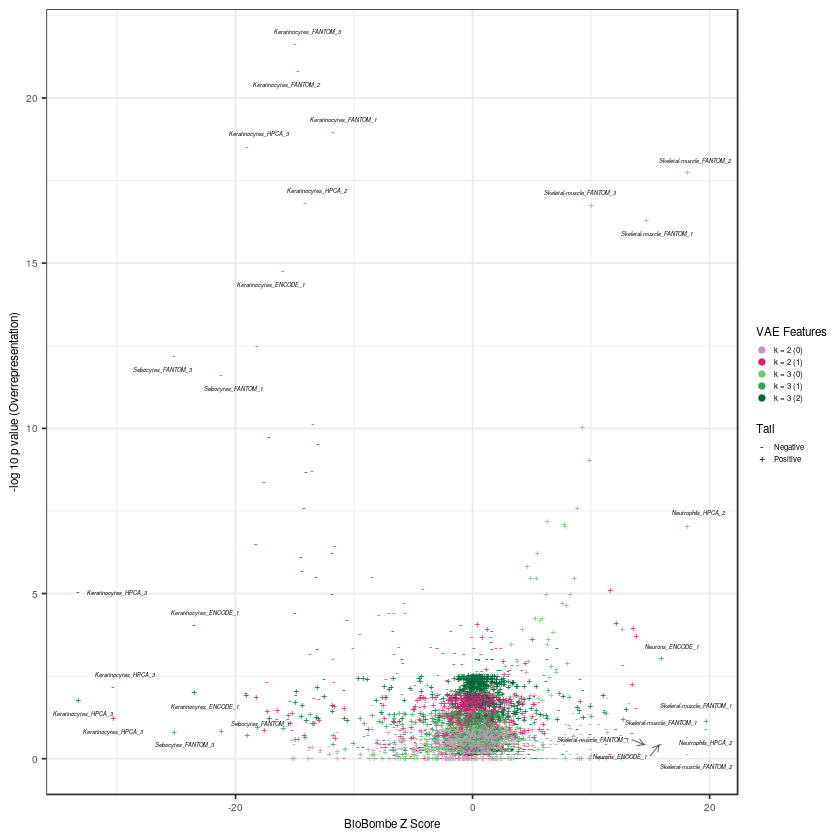

In [11]:
sup_panel_b_gg <- ggplot(combined_results_df,
                         aes(x = z_score,
                             y = neg_log10_p,
                             shape = tailed)) +
    geom_point(aes(color = as.factor(full_feature)),
               size = 2) +
    scale_color_manual(name = "VAE Features",
                       values = vae_colors,
                       labels =  vae_labels) +
    scale_shape_manual(name = "Tail",
                       values = c("-", "+"),
                       labels = c("pos" = "Positive",
                                  "neg" = "Negative")) +
    geom_text_repel(data = subset(combined_results_df, color_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    segment.size = 0.3,
                    segment.alpha = 0.6,
                    size = 1.2,
                    fontface = "italic",
                    box.padding = 0.25,
                    point.padding = 0.15,
                    aes(x = z_score,
                        y = neg_log10_p,
                        label = variable)) +
    xlab("BioBombe Z Score") +
    ylab("-log 10 p value (Overrepresentation)") +
    theme_bw() +
    theme(axis.title = element_text(size = 7),
          axis.text.x = element_text(size = 6),
          axis.text.y = element_text(size = 6),
          legend.position = 'right',
          legend.title = element_text(size = 7),
          legend.text = element_text(size = 4.7),
          legend.margin = margin(0, 0, 0, 0),
          legend.box.margin = margin(-8, 0, 0, 0)) +
    guides(color = guide_legend(order = 1,
                                nrow = 5,
                                ncol = 1,
                                byrow = FALSE,
                                keywidth = 0.1,
                                keyheight = 0.1,
                                default.unit = "inch",
                                override.aes = list(size = 1.4,
                                                    alpha = 1)),
           shape = guide_legend(order = 2,
                                nrow = 2,
                                ncol = 1,
                                byrow = FALSE,
                                keywidth = 0.1,
                                keyheight = 0.1,
                                default.unit = "inch"))

sup_panel_b_gg

### Supplementary Figure 1 Panel C: Comparing High Scoring Neutrophil Features (xCell Genesets)

VAE feature 0 in z = 3 vs. VAE feature 10 in z = 14.

In [12]:
# Load and process data
file <- file.path('results', 'latent_feature_enrichment_comparison_neutrophil_genesets.tsv')
geneset_weights_df <- (
    readr::read_tsv(file,
                    col_types = readr::cols(.default = readr::col_double(),
                                            model_type_z3 = readr::col_character(),
                                            variable = readr::col_character(),
                                            algorithm_z3 = readr::col_character(),
                                            model_type_z14 = readr::col_character(),
                                            algorithm_z14 = readr::col_character()))
    ) %>%
    dplyr::filter(feature_z3 == 0,
                  feature_z14 == 10)

head(geneset_weights_df, 3)

model_type_z3,variable,value_z3,z_score_z3,algorithm_z3,feature_z3,z_z3,seed_z3,model_type_z14,value_z14,z_score_z14,algorithm_z14,feature_z14,z_z14,seed_z14
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
real,Keratinocytes_HPCA_3,1.395400,5.91483,vae,0,3,908341,real,-2.46113,-5.42071,vae,10,14,486191
real,Sebocytes_FANTOM_3,1.278630,4.36728,vae,0,3,908341,real,-1.80624,-3.52964,vae,10,14,486191
real,Keratinocytes_ENCODE_1,0.994284,3.20316,vae,0,3,908341,real,-1.31071,-2.91931,vae,10,14,486191


In [13]:
# Process plotting logic
color_logic <- ((geneset_weights_df$z_score_z3 < -9 | geneset_weights_df$z_score_z3 > 10) |
                (geneset_weights_df$z_score_z14 < -10 | geneset_weights_df$z_score_z14 > 10))

In [14]:
# Formula to plot linear model
formula <- y ~ x

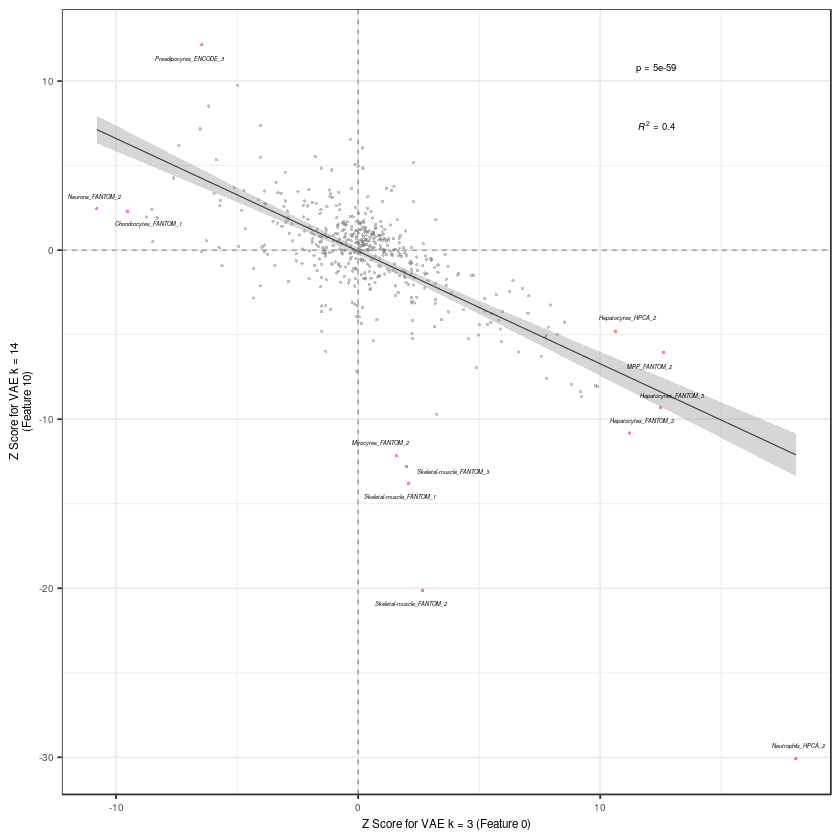

In [15]:
sup_panel_c_gg <- ggplot(geneset_weights_df,
                     aes(x = z_score_z3, y = z_score_z14)) +
    geom_point(alpha = 0.5,
               size = 0.6,
               shape = 16,
               color = ifelse(color_logic, "red", "grey50")) +
    geom_smooth(method = "lm",
                formula = formula,
                se = TRUE,
                color = "grey20",
                alpha = 0.4,
                lwd = 0.3) +
    geom_hline(yintercept = 0,
               linetype = 'dashed',
               color = 'grey50',
               lwd = 0.3) +
    geom_vline(xintercept = 0,
               linetype = 'dashed',
               color = 'grey50',
               lwd = 0.3) +
    geom_text_repel(data = subset(geneset_weights_df, color_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    segment.size = 0.3,
                    segment.alpha = 0.6,
                    size = 1.2,
                    fontface = "italic",
                    box.padding = 0.25,
                    point.padding = 0.15,
                    aes(x = z_score_z3,
                        y = z_score_z14,
                        label = variable)) +
    ggpmisc::stat_poly_eq(aes(label = paste(..rr.label..)),
                 label.x.npc = 0.8,
                 label.y.npc = 0.88,
                 formula = formula,
                 parse = TRUE,
                 size = 2,
                 na.rm = TRUE,
                 rr.digits = 1) +
    ggpmisc::stat_fit_glance(method = "lm",
                    geom = "text",
                    label.x.npc = 0.8,
                    label.y.npc = 0.97,
                    method.args = list(formula = formula),
                    size = 2,
                    aes(label = paste("p = ",
                                      signif(..p.value.., digits = 1),
                                      sep = ""))) +
    xlab("Z Score for VAE k = 3 (Feature 0)") +
    ylab("Z Score for VAE k = 14\n(Feature 10)") +
    theme_bw() +
    theme(axis.title = element_text(size = 7),
          axis.text.x = element_text(size = 6),
          axis.text.y = element_text(size = 6))

sup_panel_c_gg

### Supplementary Figure 1 Panel D: Comparing High Scoring Neutrophil Features (Compression Algorithm Gene Weights)

VAE feature 0 in k = 3 vs. VAE feature 10 in k = 14.

In [16]:
# Load and Process Data
file <- file.path('results', 'latent_feature_enrichment_comparison_neutrophil_genes.tsv')
gene_weights_df <- (
    readr::read_tsv(file,
                    col_types = readr::cols(.default = readr::col_double(),
                                            classification = readr::col_character(),
                                            gene = readr::col_character(),
                                            gene_set = readr::col_character()))
    )

geneset_classes <- c('Neutrophils',
                     'Monocytes',
                     'Keratinocytes',
                     'Skeletal Muscle',
                     'Neurons',
                     'Other Geneset',
                     'No Geneset')

gene_weights_df$classification <- factor(gene_weights_df$classification,
                                         levels = geneset_classes,
                                         ordered = TRUE)

head(gene_weights_df, 3)

pca_0_3,pca_1_3,pca_2_3,ica_0_3,ica_1_3,ica_2_3,nmf_0_3,nmf_1_3,nmf_2_3,vae_0_3,⋯,dae_7,dae_8,dae_9,dae_10,dae_11,dae_12,dae_13,classification,gene,gene_set
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<chr>,<chr>
0.004391464,-0.003970687,0.001467488,-8.481382e-07,-1.254248e-05,-1.275558e-05,0,0,0.03380259,0.3143627,⋯,-0.3339936,-0.1064593,-0.3976925,0.07037536,-0.1320517,-0.1052270,-0.0405535,Neutrophils,3043,Neutrophils_HPCA_3
0.003391244,-0.003176907,0.001365653,-1.476440e-06,-1.026097e-05,-1.011298e-05,0,0,0.02834835,0.2944924,⋯,-0.2973784,-0.1857497,-0.3814140,0.07469460,-0.2686870,-0.2286410,-0.1678598,No Geneset,No Geneset,No Geneset
0.001971815,-0.005422603,0.007662888,-2.523095e-05,-2.307387e-05,-1.471192e-05,0,0,0.08123793,0.2559635,⋯,-0.1777977,-0.5945446,-0.4956011,0.07055295,-0.6175677,-0.5836463,-0.5123734,Keratinocytes,6280,Keratinocytes_FANTOM_3


In [17]:
color_labels <- c("Neutrophils" = "#1b9e77",
                  "Keratinocytes" = "#6a3d9a",
                  "Neurons" = "#1f78b4",
                  "Skeletal Muscle" = "#ff7f00",
                  "Monocytes" = "#e7298a",
                  "Other Geneset" = "#CFDEDA",
                  "No Geneset" = "#F5B8D4")

`geom_smooth()` using formula 'y ~ x'



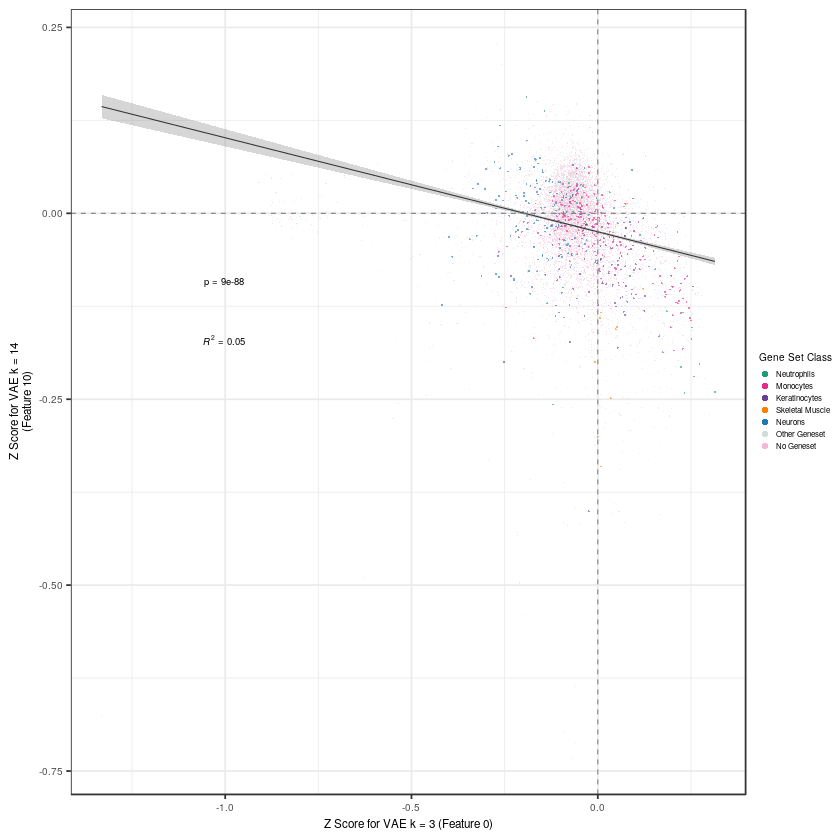

In [18]:
other_points_logic <- gene_weights_df$classification %in% c('Other Geneset', 'No Geneset')

sup_panel_d_gg <- ggplot(gene_weights_df,
                     aes(x = vae_0_3,
                         y = vae_10)) +
    geom_point(data = subset(gene_weights_df, other_points_logic),
               aes(color = classification),
               shape = 16,
               size = 0.02,
               alpha = 0.4) +
    geom_point(data = subset(gene_weights_df, !other_points_logic),
               aes(color = classification),
               shape = 16,
               size = 0.2,
               alpha = 0.6) +
    geom_smooth(method = "lm",
                se = TRUE,
                color = "grey20",
                alpha = 0.4,
                lwd = 0.3) +
    geom_hline(yintercept = 0,
               linetype = 'dashed',
               color = 'grey50',
               lwd = 0.3) +
    geom_vline(xintercept = 0,
               linetype = 'dashed',
               color = 'grey50',
               lwd = 0.3) +
    stat_poly_eq(data = gene_weights_df, 
                 aes(label = paste(..rr.label..)),
                 label.x.npc = 0.2,
                 label.y.npc = 0.58,
                 formula = formula,
                 parse = TRUE,
                 size = 2,
                 na.rm = TRUE,
                 rr.digits = 1) +
    stat_fit_glance(method = "lm",
                    geom = "text",
                    label.x.npc = 0.2,
                    label.y.npc = 0.67,
                    method.args = list(formula = formula),
                    size = 2,
                    aes(label = paste("p = ",
                                      signif(..p.value.., digits = 1),
                                      sep = ""))) +
    scale_color_manual(name = "Gene Set Class",
                       values = color_labels,
                       breaks = geneset_classes) +
    xlab("Z Score for VAE k = 3 (Feature 0)") +
    ylab("Z Score for VAE k = 14\n(Feature 10)") +
    theme_bw() +
    theme(axis.title = element_text(size = 7),
          axis.text.x = element_text(size = 6),
          axis.text.y = element_text(size = 6),
          legend.text = element_text(size = 4.7),
          legend.title = element_text(size = 6),
          legend.margin = margin(t = 0, r = 0, b = 0, l = 0),
          legend.box.margin = margin(t = -3, r = 0, b = -3, l = -3)) +
    guides(color = guide_legend(keywidth = 0.1,
                                keyheight = 0.1,
                                default.unit = "inch",
                                override.aes = list(size = 1.4,
                                                    alpha = 1)))

sup_panel_d_gg

## Compile Supplementary Figure

`geom_smooth()` using formula 'y ~ x'



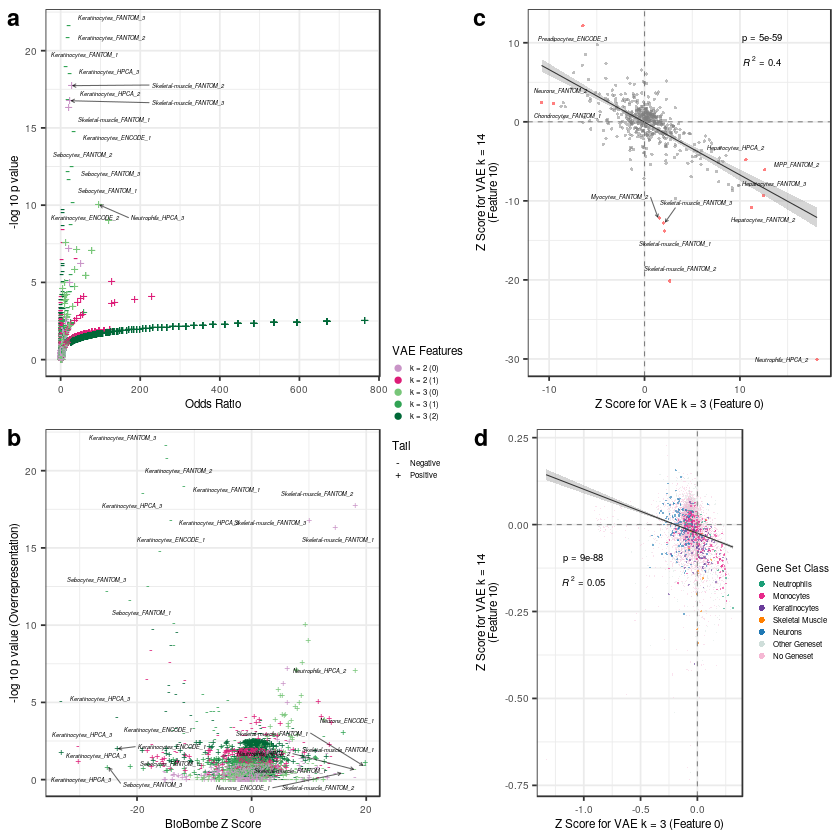

In [19]:
legend_gg <- cowplot::get_legend(sup_panel_b_gg)

sup_panel_a_and_b_gg <- cowplot::plot_grid(
    sup_panel_a_gg +
        theme(legend.position = 'none'),
    sup_panel_b_gg +
        theme(legend.position = 'none'),
    nrow = 2,
    labels = c("a", "b"),
    rel_heights = c(1, 1)
)

sup_panel_a_and_b_gg <- cowplot::plot_grid(
    sup_panel_a_and_b_gg,
    legend_gg,
    rel_widths = c(1, 0.2),
    ncol = 2
)

sup_panel_c_and_d_gg <- cowplot::plot_grid(
    sup_panel_c_gg,
    sup_panel_d_gg,
    nrow = 2,
    labels = c("c", "d"),
    rel_widths = c(1, 1)
)

sup_gg <- cowplot::plot_grid(
    sup_panel_a_and_b_gg,
    sup_panel_c_and_d_gg,
    ncol = 2,
    labels = c("", ""),
    rel_widths = c(1, 0.8)
)

sup_gg

In [20]:
for(extension in fig_extensions) {
    gg_file <- paste0("gtex_biobombe_supplementary_figure", extension)
    gg_file <- file.path("figures", gg_file)
    cowplot::save_plot(filename = gg_file,
                       plot = sup_gg,
                       base_height = 130,
                       base_width = 170,
                       units = "mm",
                       dpi = 500)
}

## Part 2 - Generate Supplementary Figure 2

### Supplementary Figure 2 Panel A - 

Visualize t-test among all top compression features for Neutrophils and Monocytes in publicly available datasets

In [21]:
cell_types <- c(
  "Neutrophil", "Monocyte"
)

line_plot <- list()
for (cell_type in cell_types) {
    file <- file.path("results", paste0("all_", tolower(cell_type),
                                        "_top_scores_and_separation.tsv"))
    final_results_df <- readr::read_tsv(file,
                                        col_types = readr::cols(
                                            .default = readr::col_integer(),
                                            algorithm = readr::col_character(),
                                            t_stat = readr::col_double(),
                                            t_p = readr::col_double(),
                                            neg_log_p = readr::col_double(),
                                            variable = readr::col_character(),
                                            model_type = readr::col_character(),
                                            value = readr::col_double(),
                                            z_score = readr::col_double(),
                                            abs_z_score = readr::col_double()))
    final_results_df$algorithm <- 
      dplyr::recode(final_results_df$algorithm,
                    "pca" = "PCA", "ica" = "ICA", "nmf" = "NMF", "dae" = "DAE",
                    "vae" = "VAE")
  
    # Create factors for plotting
    final_results_df$z <-
      factor(final_results_df$z,
             levels =
               sort(as.numeric(paste(unique(final_results_df$z))))
      )
  
    final_results_df$algorithm <-
      factor(final_results_df$algorithm,
             levels = c("PCA", "ICA", "NMF", "DAE", "VAE"))
  
    final_results_df <- final_results_df %>% dplyr::arrange(z)

    # Generate plot title
    if (cell_type == "Neutrophil") {
        gse <- "GSE103706"
    } else {
        gse <- "GSE24759"
    }
    plot_title <- paste(cell_type, "-", gse)

    line_plot[[cell_type]] <- # Plot and save to file
      ggplot(final_results_df,
             aes(x = z,
                 y = neg_log_p,
                 color = algorithm,
                 group = algorithm)) +
      geom_point(size = 0.1) +
      geom_smooth(lwd = 0.2,
                  formula = y ~ x,
                  method = "loess",
                  alpha = 0.2,
                  aes(fill = algorithm)) +
      scale_color_manual(name = "Algorithm",
                         values = c("#e41a1c",
                                    "#377eb8",
                                    "#4daf4a",
                                    "#984ea3",
                                    "#ff7f00"),
                         labels = c("pca" = "PCA",
                                    "ica" = "ICA",
                                    "nmf" = "NMF",
                                    "dae" = "DAE",
                                    "vae" = "VAE")) +
      scale_fill_manual(name = "Algorithm",
                        values = c("#e41a1c",
                                   "#377eb8",
                                   "#4daf4a",
                                   "#984ea3",
                                   "#ff7f00"),
                        labels = c("pca" = "PCA",
                                   "ica" = "ICA",
                                   "nmf" = "NMF",
                                   "dae" = "DAE",
                                   "vae" = "VAE")) +
      theme_bw() +
      ggtitle(plot_title) +
      ylab("-log 10 P") +
      xlab("k Dimensions") +
      theme(axis.title.x = element_text(size = 7),
            axis.title.y = element_text(size = 7),
            axis.text.x = element_text(angle = 90,
                                     size = 5),
            axis.text.y = element_text(size = 6),
            plot.title = element_text(hjust = 0.5,
                                    size = 8),
            legend.text = element_text(size = 6),
            legend.title = element_text(size = 7),
            legend.key.size = unit(0.7, "lines"))
}

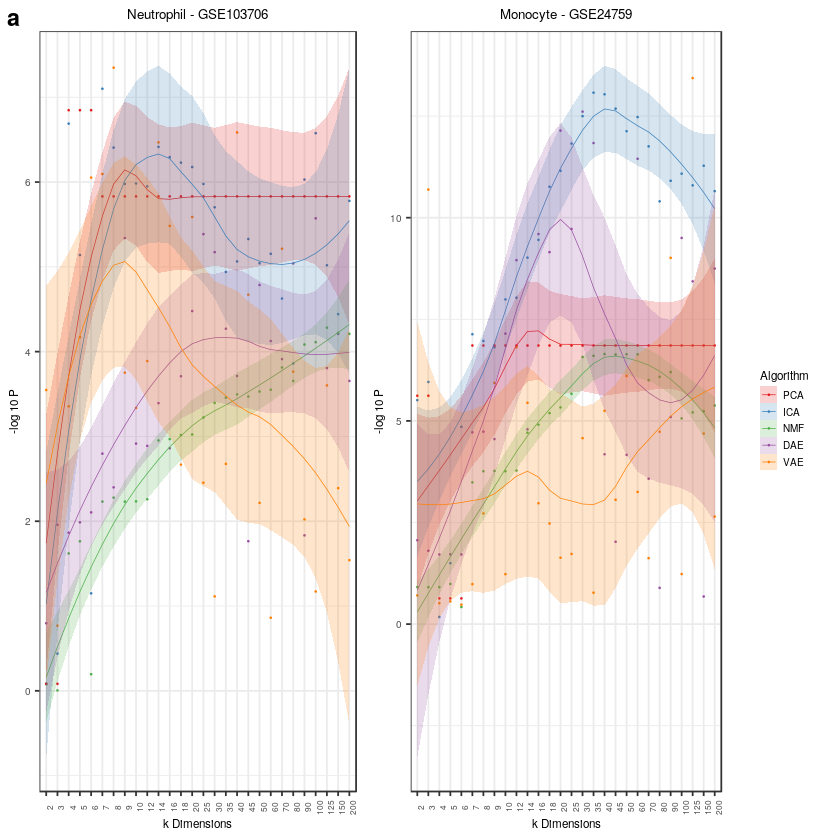

In [22]:
# Plot
line_legend <- cowplot::get_legend(line_plot[['Neutrophil']])
sup_fig_2_panel_a_gg <- cowplot::plot_grid(
    line_plot[['Neutrophil']] + theme(legend.position = "none"),
    line_plot[['Monocyte']] + theme(legend.position = "none"),
    labels = c("a", ""),
    ncol = 2
)

sup_fig_2_panel_a_gg <- cowplot::plot_grid(
    sup_fig_2_panel_a_gg,
    line_legend,
    rel_widths = c(1, 0.15),
    ncol = 2
)

sup_fig_2_panel_a_gg

## Supplementary Figure 2 Panel B 

Comparing t-test to BioBombe Z Scores

In [23]:
myPalette <- colorRampPalette(rev(c("#43b8d8",
                                    "#9e5eed",
                                    "#ef07c4",
                                    "#ef0707")))

In [24]:
career_path_plot <- list()
for (cell_type in cell_types) {
    file <- file.path("results", paste0("all_", tolower(cell_type),
                                      "_top_scores_and_separation.tsv"))
    final_results_df <- readr::read_tsv(file,
                                        col_types = readr::cols(
                                            .default = readr::col_integer(),
                                            algorithm = readr::col_character(),
                                            t_stat = readr::col_double(),
                                            t_p = readr::col_double(),
                                            neg_log_p = readr::col_double(),
                                            variable = readr::col_character(),
                                            model_type = readr::col_character(),
                                            value = readr::col_double(),
                                            z_score = readr::col_double(),
                                            abs_z_score = readr::col_double()))
    final_results_df$algorithm <- 
    dplyr::recode(final_results_df$algorithm,
                  "pca" = "PCA", "ica" = "ICA", "nmf" = "NMF", "dae" = "DAE",
                  "vae" = "VAE")

    # Create factors for plotting
    final_results_df$z <-
    factor(final_results_df$z,
           levels =
             sort(as.numeric(paste(unique(final_results_df$z))))
    )

    final_results_df$algorithm <-
    factor(final_results_df$algorithm,
           levels = c("PCA", "ICA", "NMF", "DAE", "VAE"))

    final_results_df <- final_results_df %>% dplyr::arrange(z)

    career_path_plot[[cell_type]] <-
    ggplot(final_results_df,
                          aes(y = neg_log_p,
                              x = abs_z_score,
                              group = algorithm)) +
    geom_point(size = 0.1, alpha = 0.9) +
    geom_path(aes(color = z_dim),
              lwd = 0.2) +
    facet_wrap(~algorithm, ncol = 5) +
    scale_color_gradientn(name = "k Dimension",
                          colours = myPalette(300),
                          values = scales::rescale(c(200, 125, 25, 10, 0)),
                          limits = c(0, 200)) +
    theme_bw() +
    ylab("-log10 P") +
    xlab("BioBombe Score") +
    theme(strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"),
          strip.text.x = element_text(size = 5,
                                      margin = margin(t = 2,
                                                      b = 1,
                                                      l = 0,
                                                      r = 0)),
          axis.title.x = element_text(size = 7),
          axis.title.y = element_text(size = 7),
          axis.text.x = element_text(angle = 90,
                                     size = 5),
          axis.text.y = element_text(size = 6),
          legend.text = element_text(size = 6),
          legend.title = element_text(size = 7),
          legend.key.size = unit(0.7, "lines"))
}

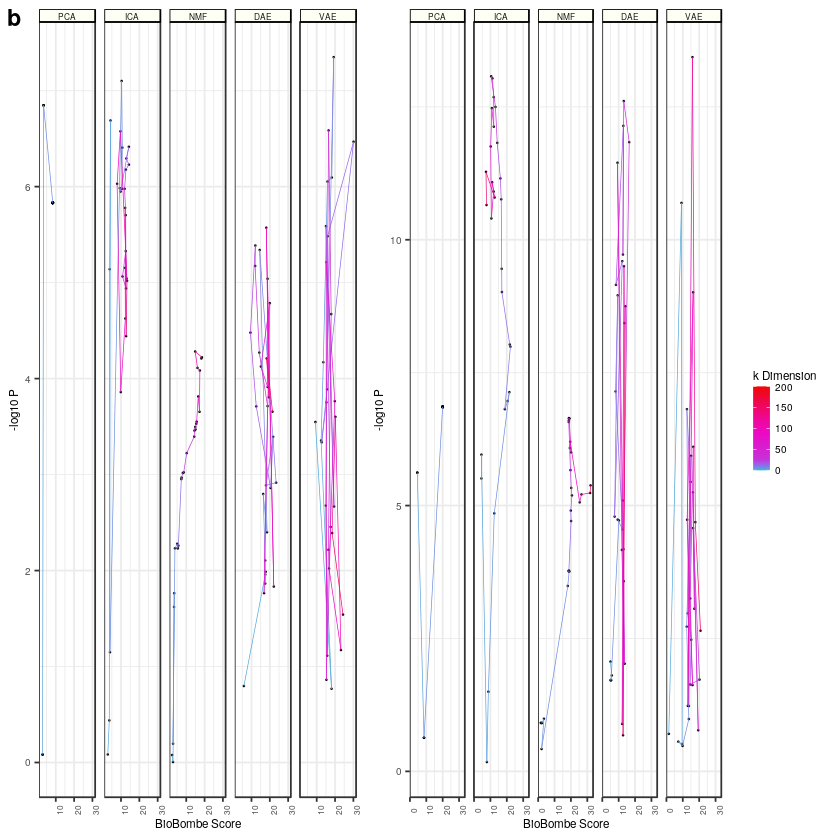

In [25]:
career_legend <- cowplot::get_legend(career_path_plot[['Neutrophil']])

sup_fig_2_panel_b_gg <- cowplot::plot_grid(
    career_path_plot[['Neutrophil']] + theme(legend.position = "none"),
    career_path_plot[['Monocyte']] + theme(legend.position = "none"),
    labels = c("b", ""),
    ncol = 2
)

sup_fig_2_panel_b_gg <- cowplot::plot_grid(
    sup_fig_2_panel_b_gg,
    career_legend,
    rel_widths = c(1, 0.15),
    ncol = 2
)

sup_fig_2_panel_b_gg

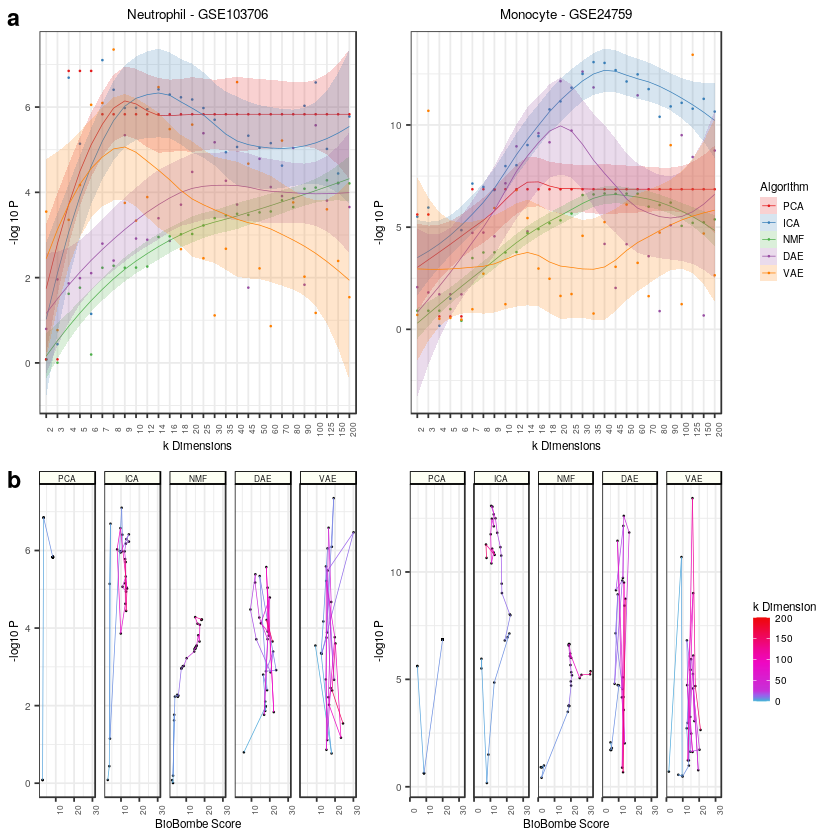

In [26]:
sup_fig_2_panel_a_and_b_gg <- cowplot::plot_grid(
    sup_fig_2_panel_a_gg,
    sup_fig_2_panel_b_gg,
    nrow = 2,
    rel_heights = c(1.1, 0.9)
)

sup_fig_2_panel_a_and_b_gg

In [27]:
for(extension in fig_extensions) {
    gg_file <- paste0("gtex_biobombe_supplementary_validation_figure", extension)
    gg_file <- file.path("figures", gg_file)
    cowplot::save_plot(filename = gg_file,
                       plot = sup_fig_2_panel_a_and_b_gg,
                       base_height = 110,
                       base_width = 170,
                       units = "mm",
                       dpi = 500)
}

## Part 3 - Generate Main Figure

### Main Figure Panel A - Determining which genesets are enriched in each VAE feature for k = 2 and k = 3

In [28]:
# Load and process data
results_file <- file.path('results', 'gtex_vae_example_interpret_compression.tsv')
interpret_data_df <- (
    readr::read_tsv(results_file,
                    col_types = readr::cols(.default = readr::col_character(),
                                            raw_score = readr::col_double(),
                                            z_score = readr::col_double()))
    )

interpret_data_df$full_feature <- factor(interpret_data_df$full_feature,
                                  levels = c("vae_0_two", "vae_1_two", "vae_0_three",
                                             "vae_1_three", "vae_2_three"))

In [29]:
# Setup plotting logic
vae_labels <- c("vae_0_two" = "k = 2 (0)",
                "vae_1_two" = "k = 2 (1)",
                "vae_0_three" = "k = 3 (0)",
                "vae_1_three" = "k = 3 (1)",
                "vae_2_three" = "k = 3 (2)")

vae_colors <- c("#c994c7", "#dd1c77", "#78c679", "#31a354", "#006837")

color_logic <- (interpret_data_df$z_score > 13 |
                interpret_data_df$z_score < -18 |
                interpret_data_df$raw_score < -22)

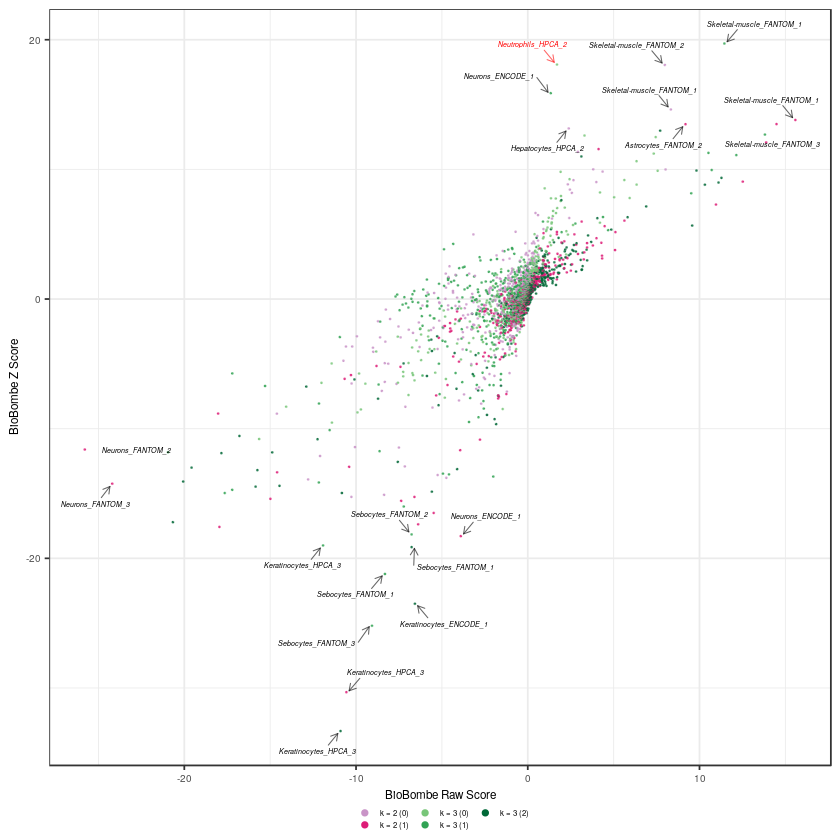

In [30]:
# Plot
neutrophil_points_df <- subset(interpret_data_df, color_logic)
num_points <- dim(neutrophil_points_df)[1]
neutrophil_colors <- rep("black", num_points)
neutrophil_colors[neutrophil_points_df$variable == 'Neutrophils_HPCA_2'] <- "red"

panel_a_gg <- ggplot(interpret_data_df,
                     aes(x = raw_score,
                         y = z_score)) +
    geom_point(aes(color = full_feature),
               size = 0.14,
               alpha = 0.65) +
    scale_color_manual(name = "",
                       values = vae_colors,
                       labels =  vae_labels) +
    geom_text_repel(data = neutrophil_points_df,
                    arrow = arrow(length = unit(0.01, "npc")),
                    color = neutrophil_colors,
                    segment.size = 0.3,
                    segment.alpha = 0.6,
                    size = 1.5,
                    fontface = "italic",
                    box.padding = 0.47,
                    point.padding = 0.23,
                    aes(x = raw_score,
                        y = z_score,
                        label = variable)) +
    xlab("BioBombe Raw Score") +
    ylab("BioBombe Z Score") +
    theme_bw() +
    theme(axis.title = element_text(size = 7),
          axis.text.x = element_text(size = 6),
          axis.text.y = element_text(size = 6),
          legend.position = 'bottom',
          legend.text = element_text(size = 4.7),
          legend.margin = margin(0, 0, 0, 0),
          legend.box.margin = margin(-8, 0, 0, 0)) +
    guides(color = guide_legend(nrow = 2,
                                ncol = 3,
                                byrow = FALSE,
                                keywidth = 0.1,
                                keyheight = 0.1,
                                default.unit = "inch",
                                override.aes = list(size = 1.4,
                                                    alpha = 1)))

panel_a_gg

### Panel B - Determining which genesets are enriched on average in both VAE models (k = 2 vs. k = 3)

In [31]:
# Load and process data
file <- file.path('results', 'gtex_vae_example_differentiating_features.tsv')
feature_info_df <- readr::read_tsv(file,
                                   col_types = readr::cols(.default = readr::col_double(),
                                                           variable = readr::col_character()))

In [32]:
# Setup plotting logic
color_logic = feature_info_df$abs_diff > 3.5 | feature_info_df$two > 13  | feature_info_df$three > 13

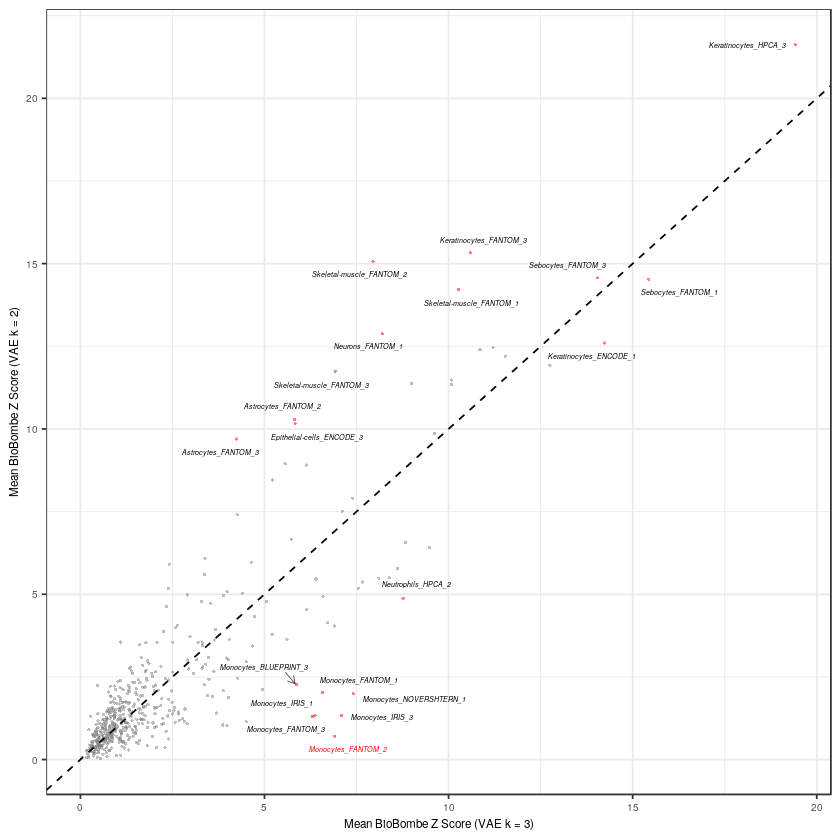

In [33]:
# Plot
monocyte_points_df <- subset(feature_info_df, color_logic)
num_points <- dim(monocyte_points_df)[1]
monocyte_colors <- rep("black", num_points)
monocyte_colors[monocyte_points_df$variable == 'Monocytes_FANTOM_2'] <- "red"

panel_b_gg <- ggplot(feature_info_df, aes(x = three, y = two)) +
    geom_point(alpha = 0.5,
               size = 0.6,
               shape = 16,
               color = ifelse(color_logic, "red", "grey50")) +
    geom_abline(intercept = 0, slope = 1, linetype = 'dashed') +
    geom_text_repel(data = monocyte_points_df,
                    arrow = arrow(length = unit(0.01, "npc")),
                    color = monocyte_colors,
                    segment.size = 0.3,
                    segment.alpha = 0.6,
                    size = 1.5,
                    fontface = "italic",
                    box.padding = 0.25,
                    point.padding = 0.15,
                    aes(x = three,
                        y = two,
                        label = variable)) +
    xlab("Mean BioBombe Z Score (VAE k = 3)") +
    ylab("Mean BioBombe Z Score (VAE k = 2)") +
    theme_bw() +
    theme(axis.title = element_text(size = 7),
          axis.text.x = element_text(size = 6),
          axis.text.y = element_text(size = 6))
    
panel_b_gg

## Panel C - Tracking Neutrophil Signatures Across Algorithms and Dimensions

We are specically interested in tracking `Neutrophils_HPCA_2`.

In [34]:
gene_set_dir <- file.path("..", "6.biobombe-projection",
                          "results", "gtex",
                          "gpxcell", "signal")
metaedge <- "GpXCELL"
dataset <- "GTEX"

In [35]:
# Compile all results (use this for plotting later)
biobombe_results_df <- get_biobombe_results(gene_set_dir = gene_set_dir)

Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”


In [36]:
line_plot_theme <-
    theme(strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"),
          strip.text = element_text(size = 6),
          axis.title = element_text(size = 7),
          axis.title.x = element_text(margin = margin(t = 0.1,
                                                      r = 0,
                                                      b = 0,
                                                      l = 0,
                                                      unit = 'cm')),
          axis.text.x = element_text(size = 5),
          axis.text.y = element_text(size = 6),
          legend.text = element_text(size = 4.7),
          legend.title = element_text(size = 6),
          legend.margin = margin(t = 0,
                                 r = 0,
                                 b = 0,
                                 l = 0),
          legend.box.margin = margin(t = -3,
                                     r = 0,
                                     b = -3,
                                     l = -3))

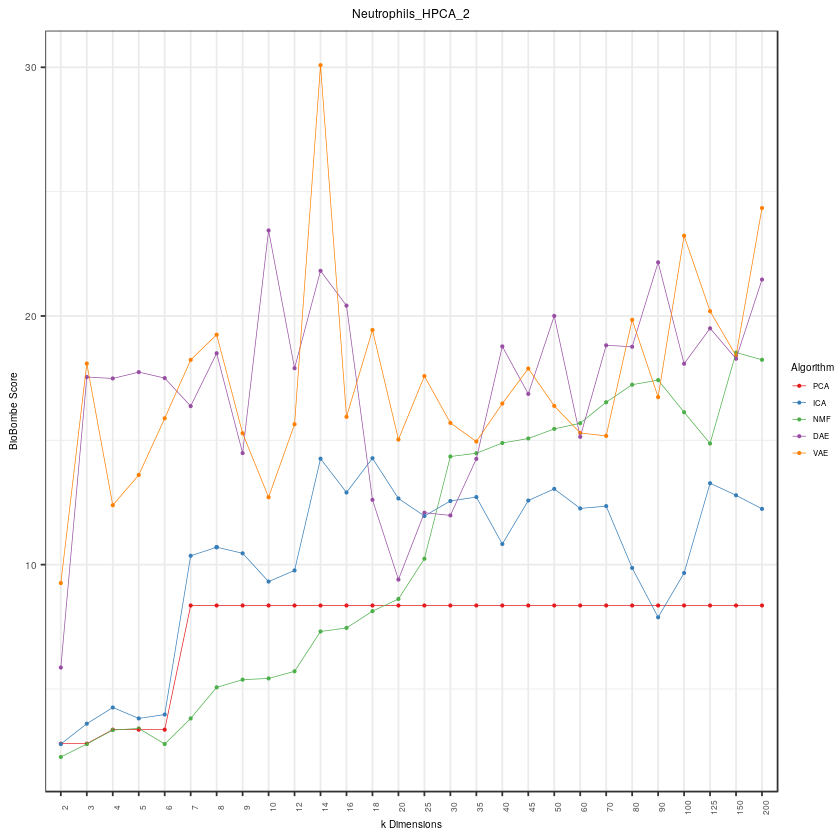

In [37]:
panel_c_gg <- plot_gene_set(gene_set = "Neutrophils_HPCA_2",
                            full_results_df = biobombe_results_df,
                            metaedge = metaedge,
                            dataset = dataset,
                            show_plot = FALSE,
                            shuffled = FALSE,
                            return_top = FALSE,
                            return_plot = TRUE)

panel_c_gg <- panel_c_gg +
    line_plot_theme +
    ylab("BioBombe Score") +
    theme(title = element_text(size = 6),
          axis.title.y = element_text(size = 6),
          axis.title.x = element_text(size = 6))

panel_c_gg

## Panel D - Tracking Monocyte Signatures Across Algorithms and Dimensions

We are specically interested in tracking `Monocytes_FANTOM_2`.

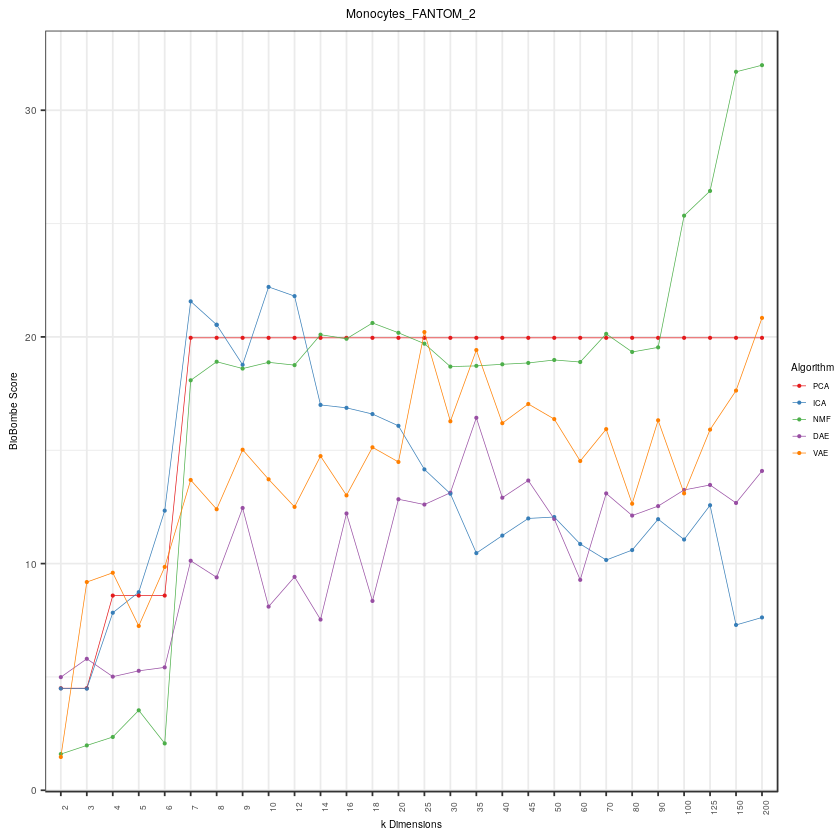

In [38]:
panel_d_gg <- plot_gene_set(gene_set = "Monocytes_FANTOM_2",
                            full_results_df = biobombe_results_df,
                            metaedge = metaedge,
                            dataset = dataset,
                            show_plot = FALSE,
                            shuffled = FALSE,
                            return_top = FALSE,
                            return_plot = TRUE)

panel_d_gg <- panel_d_gg +
    line_plot_theme +
    ylab("BioBombe Score") +
    theme(title = element_text(size = 6),
          axis.title.y = element_text(size = 6),
          axis.title.x = element_text(size = 6))

panel_d_gg

## Panel E - Applying BioBombe Signatures to External Neutrophil Dataset

Application of VAE feature 0 in k = 3 vs. VAE feature 10 in k = 14 to [GSE103706](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE103706) ([Rincon et al. 2018](https://doi.org/10.1186/s12864-018-4957-6)).

In [39]:
# Load and process data
file <- file.path('results', 'neutrophil_data_biobombe_results.tsv')
full_neutrophil_results_df <-
    readr::read_tsv(file,
                    col_types = readr::cols(.default = readr::col_double(),
                                            full_id = readr::col_character(),
                                            cell_line = readr::col_character(),
                                            treatment = readr::col_character(),
                                            day = readr::col_character()))

full_neutrophil_results_df <-
    reshape2::melt(full_neutrophil_results_df,
                   id.vars = c('full_id', 'cell_line', 'treatment', 'day'),
                   variable.vars = c('vae_10', 'vae_0'),
                   variable.name = 'feature',
                   value.name = 'score')

full_neutrophil_results_df$feature <-
    dplyr::recode_factor(full_neutrophil_results_df$feature,
                         'vae_0' = 'VAE k = 3 (Feature 0)',
                         'vae_10' = 'VAE k = 14 (Feature 10)',
                         .ordered = TRUE)

head(full_neutrophil_results_df, 3)

,full_id,cell_line,treatment,day,feature,score
,<chr>,<chr>,<chr>,<chr>,<ord>,<dbl>
1,"HL-60, DMSO+Nutridoma, day 6, replicate 1",HL-60,DMSO+Nutridoma,day 6,VAE k = 14 (Feature 10),-36.04943
2,"HL-60, DMSO+Nutridoma, day 6, replicate 2",HL-60,DMSO+Nutridoma,day 6,VAE k = 14 (Feature 10),-22.59098
3,"HL-60, DMSO, day 6, replicate 1",HL-60,DMSO,day 6,VAE k = 14 (Feature 10),-35.90992


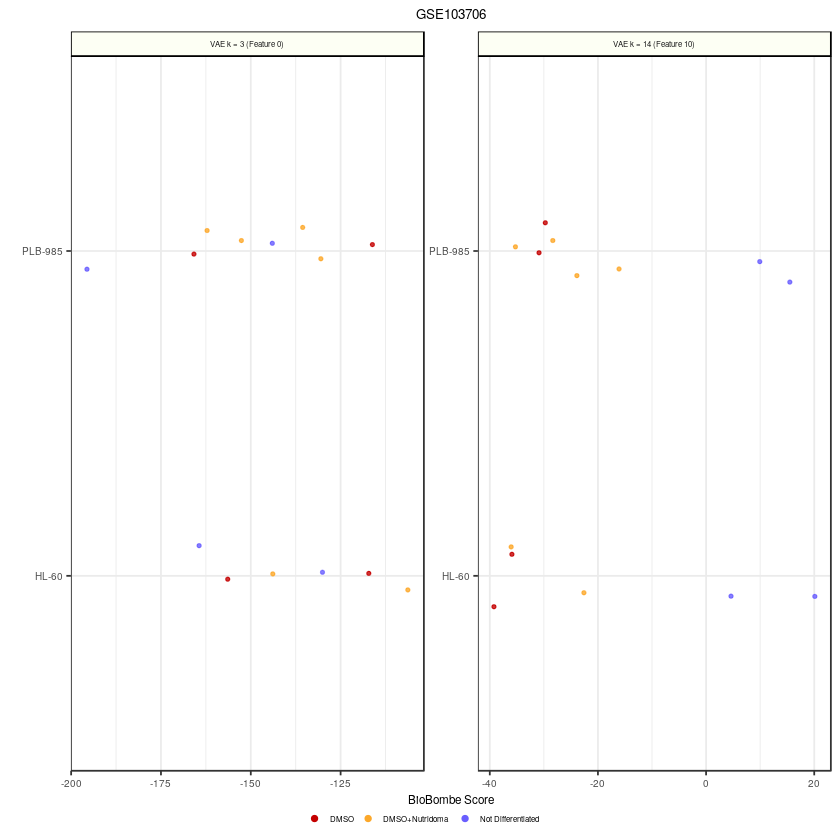

In [40]:
panel_e_gg <- ggplot(full_neutrophil_results_df,
                     aes(x = cell_line,
                         y = score)) +
    geom_jitter(aes(color = treatment),
                width = 0.1,
                height = 0,
                size = 0.8,
                alpha = 0.8) +
    coord_flip() +
    facet_wrap(~feature,
               scales = "free") +
    scale_color_manual(name = "",
                       values = c("DMSO" = "#c40000",
                                  "DMSO+Nutridoma" = "#fca82a",
                                  "Not Differentiated" = "#695eff")) +
    xlab('') +
    ylab('BioBombe Score') +
    ggtitle("GSE103706") +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5,
                                    size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"),
          strip.text = element_text(size = 4.7),
          axis.title = element_text(size = 7),
          axis.text.x = element_text(size = 6),
          axis.text.y = element_text(size = 6),
          legend.position = 'bottom',
          legend.text = element_text(size = 4.7),
          legend.margin = margin(0, 0, 0, 0),
          legend.box.margin = margin(-8, 0, 0, 0)) +
    guides(color = guide_legend(nrow = 1,
                                ncol = 5,
                                byrow = FALSE,
                                keywidth = 0.1,
                                keyheight = 0.1,
                                default.unit = "inch",
                                override.aes = list(size = 1.4,
                                                    alpha = 1)))

panel_e_gg

## Panel F - Applying BioBombe Signatures to External Monocyte Dataset

Application of VAE feature 2 in k = 3 vs. NMF feature 6 in k = 200 to [GSE24759](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE24759) ([Novershtern et al. 2011](https://doi.org/10.1016/j.cell.2011.01.004)).

In [41]:
# Load and process results
file <- file.path('results', 'hematopoietic_data_biobombe_results.tsv')

full_heme_results_df <-
    readr::read_tsv(file,
                    col_types = readr::cols(.default = readr::col_double(),
                                            cell_type = readr::col_character(),
                                            replicate = readr::col_character(),
                                            cell = readr::col_character(),
                                            cell_class = readr::col_character()))

full_heme_results_df <-
    reshape2::melt(full_heme_results_df,
                   id.vars = c('cell_type', 'replicate', 'cell', 'cell_class'),
                   variable.vars = c('vae_2', 'nmf_6'),
                   variable.name = 'feature',
                   value.name = 'score')

full_heme_results_df$feature <-
    dplyr::recode_factor(full_heme_results_df$feature,
                         'vae_2' = 'VAE k = 3 (Feature 2)',
                         'nmf_6' = 'NMF k = 200 (Feature 6)',
                         .ordered = TRUE)

head(full_heme_results_df, 3)

,cell_type,replicate,cell,cell_class,feature,score
,<chr>,<chr>,<chr>,<chr>,<ord>,<dbl>
1,BASO1,3,BASO1_3,Basophil,VAE k = 3 (Feature 2),11.587813
2,BASO1,4,BASO1_4,Basophil,VAE k = 3 (Feature 2),13.777747
3,BASO1,5,BASO1_5,Basophil,VAE k = 3 (Feature 2),4.523471


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


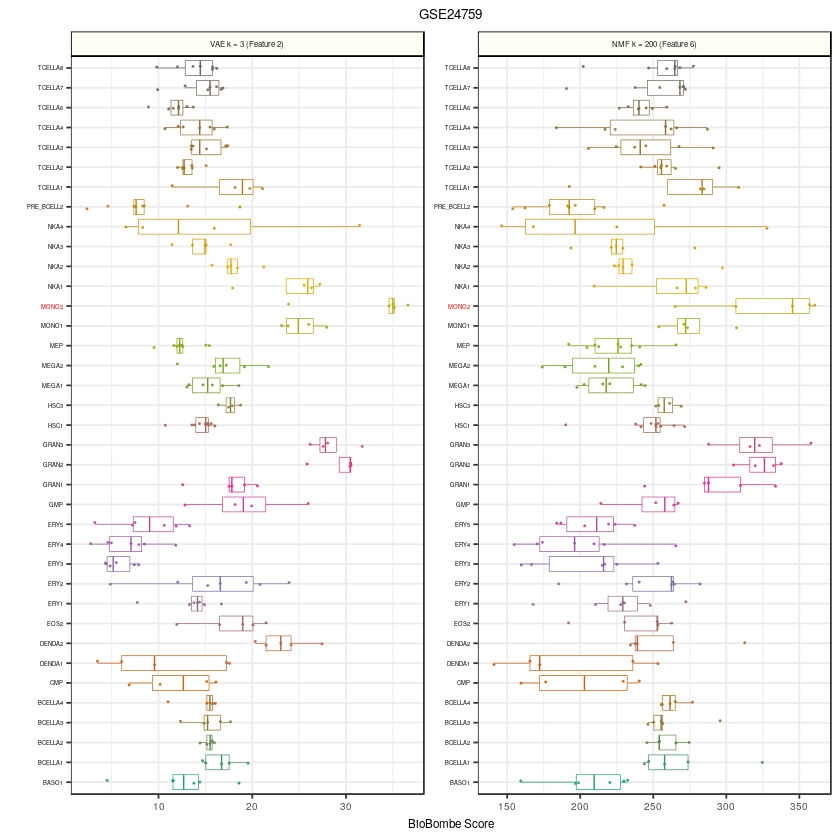

In [42]:
# Plot
n_colors <- length(unique(full_heme_results_df$cell_type))

y_axis_colors <- rep("black", n_colors)
y_axis_colors[unique(full_heme_results_df$cell_type) == 'MONO2'] <- "red"

panel_f_gg <- ggplot(full_heme_results_df,
                     aes(x = cell_type,
                         y = score)) +
    geom_boxplot(aes(color = cell_type),
                 outlier.alpha = 0,
                 lwd = 0.2) +
    geom_jitter(aes(color = cell_type),
                width = 0.1,
                size = 0.2,
                alpha = 0.8) +
    facet_wrap(~ feature, scales = "free", ncol = 2) +
    coord_flip() +
    scale_color_manual(values = colorRampPalette(RColorBrewer::brewer.pal(8, "Dark2"))(n_colors)) +
    xlab('') +
    ylab('BioBombe Score') +
    ggtitle("GSE24759") +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5,
                                    size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"),
          strip.text = element_text(size = 4.7),
          axis.title = element_text(size = 7),
          axis.text.x = element_text(size = 6),
          axis.text.y = element_text(size = 3.5,
                                     color = y_axis_colors),
          legend.position = 'none')

panel_f_gg

## Full Figure - Combine All Panels and Display with Cowplot

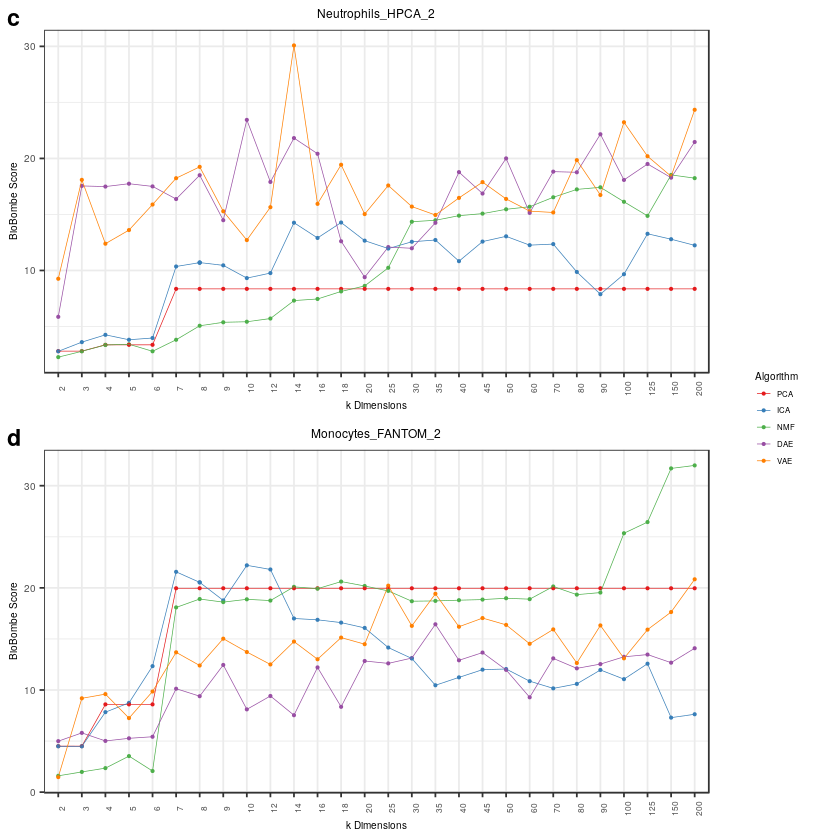

In [43]:
c_and_d_legend_gg <- cowplot::get_legend(panel_c_gg) 
c_and_d_gg <- cowplot::plot_grid(
    panel_c_gg + theme(legend.position = "none"),
    panel_d_gg + theme(legend.position = "none"),
    nrow = 2,
    labels = c("c", "d")
)

c_and_d_gg <- cowplot::plot_grid(
    c_and_d_gg,
    c_and_d_legend_gg,
    rel_widths = c(1, 0.17),
    ncol = 2
)

c_and_d_gg

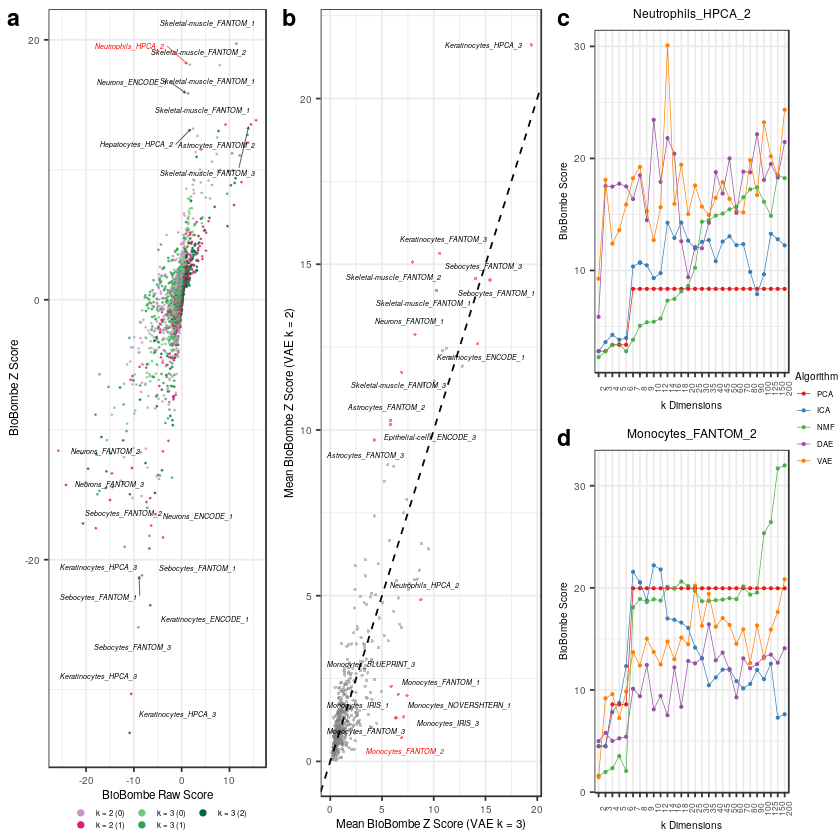

In [44]:
a_b_c_and_d_gg <- cowplot::plot_grid(
    panel_a_gg,
    panel_b_gg,
    c_and_d_gg,
    ncol = 3,
    labels = c("a", "b", ""),
    rel_widths = c(0.95, 0.95, 1)
)

a_b_c_and_d_gg

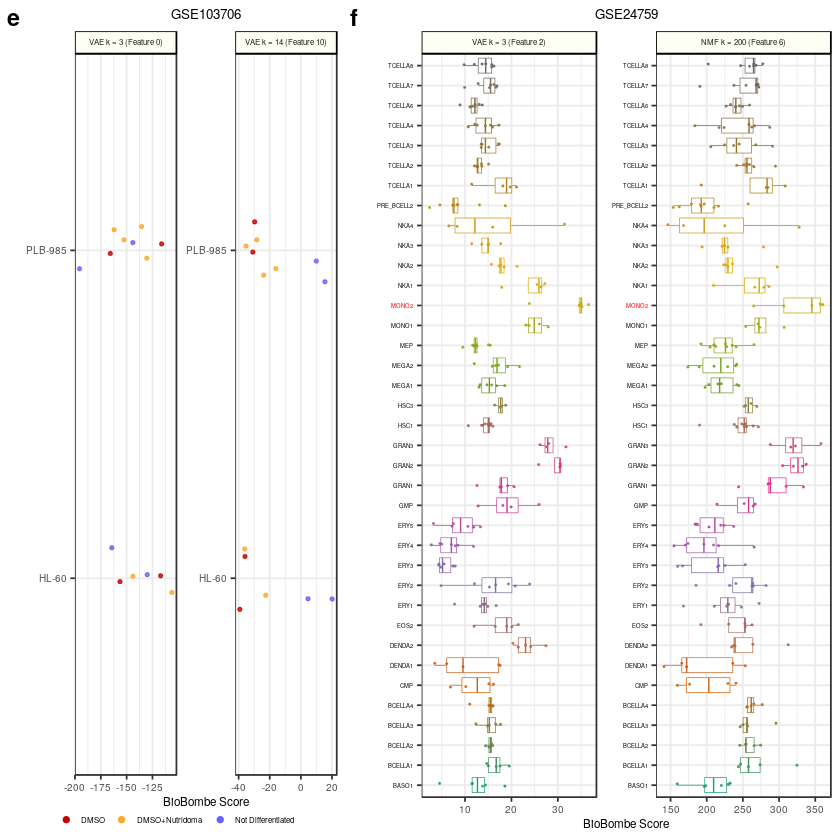

In [45]:
e_and_f_gg <- cowplot::plot_grid(
    panel_e_gg,
    panel_f_gg,
    ncol = 2,
    labels = c("e", "f"),
    rel_widths = c(0.7, 1)
)

e_and_f_gg

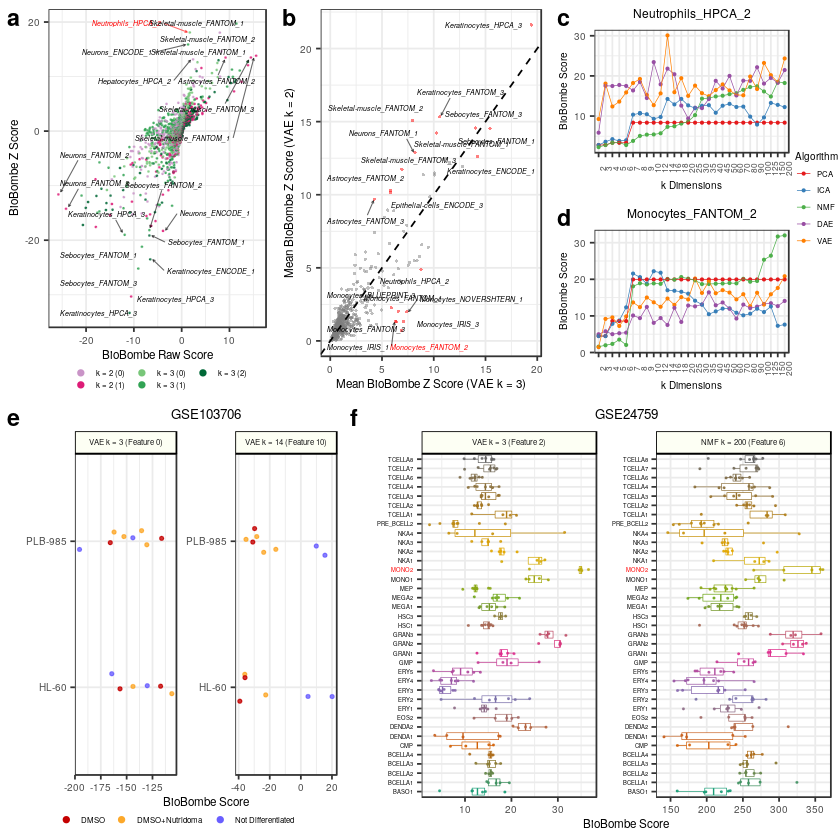

In [46]:
full_gg <- cowplot::plot_grid(
    a_b_c_and_d_gg,
    e_and_f_gg,
    nrow = 2,
    rel_heights = c(1, 1.1)
)

full_gg

In [47]:
for(extension in fig_extensions) {
    gg_file <- paste0("gtex_biobombe_main_figure", extension)
    gg_file <- file.path("figures", gg_file)
    cowplot::save_plot(filename = gg_file,
                       plot = full_gg,
                       base_height = 170,
                       base_width = 170,
                       units = "mm",
                       dpi = 500)
}